Binary Thresholding

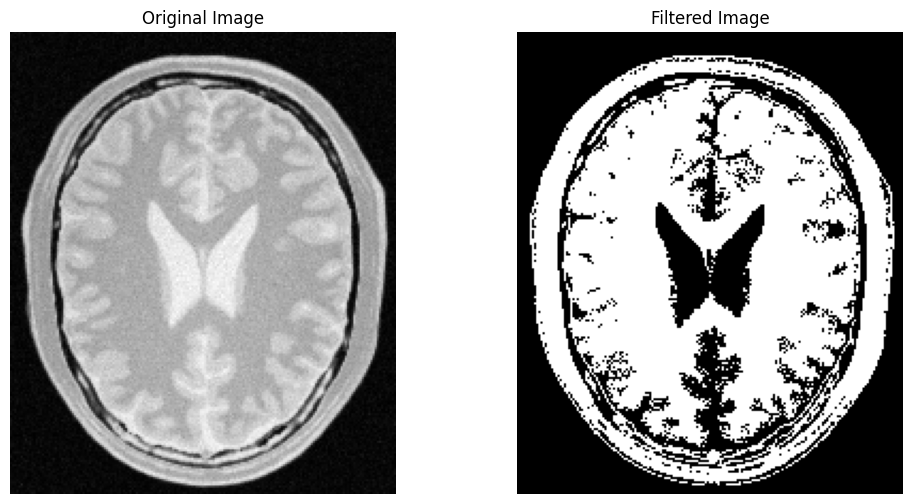

In [8]:
import itk
import matplotlib.pyplot as plt

def apply_binary_threshold(input_image, lower_threshold, upper_threshold, inside_value, outside_value):
    # Create an instance of the binary threshold filter class
    binary_threshold_filter = itk.BinaryThresholdImageFilter.New(Input=input_image)
    binary_threshold_filter.SetLowerThreshold(lower_threshold)
    binary_threshold_filter.SetUpperThreshold(upper_threshold)
    binary_threshold_filter.SetInsideValue(inside_value)
    binary_threshold_filter.SetOutsideValue(outside_value)

    binary_threshold_filter.Update()

    return binary_threshold_filter.GetOutput()

def display_images(original_image, processed_image):
    
    original_image_array = itk.array_from_image(original_image)
    processed_image_array = itk.array_from_image(processed_image)
    # array_from_image creates a copy of ITK image as a NumPy array
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_image_array, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(processed_image_array, cmap='gray')
    axes[1].set_title('Filtered Image')
    axes[1].axis('off')

    plt.show()

input_image_path = 'images\\BrainProtonDensitySlice.png'  
input_image = itk.imread(input_image_path, itk.UC)


lower_threshold = 100
upper_threshold = 200
inside_value = 255
outside_value = 0

thresholded_image = apply_binary_threshold(input_image, lower_threshold, upper_threshold, inside_value, outside_value)

display_images(input_image, thresholded_image)



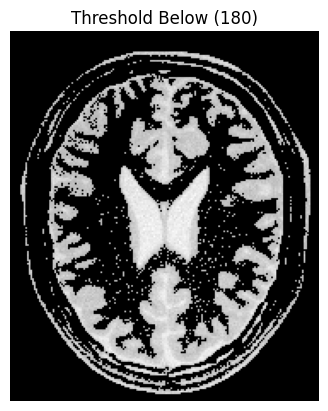

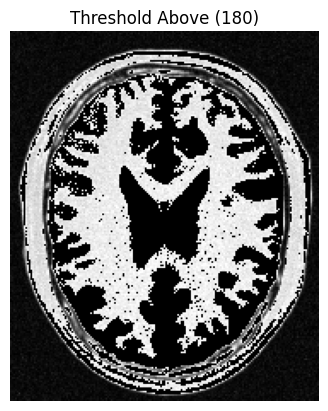

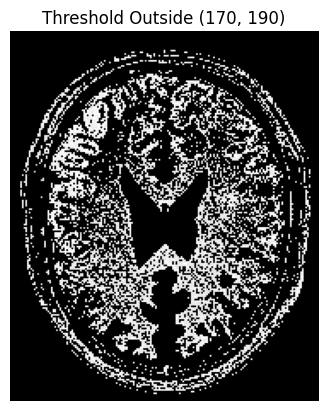

In [9]:
def display_image(image, title="Image"):
    array = itk.GetArrayViewFromImage(image)
    # This does not create a new copy but references the original image memory
    # This is a fast operation as no memory is copied

    plt.imshow(array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Define pixel and image types
PixelType = itk.UC  # Unsigned Char
Dimension = 2
ImageType = itk.Image[PixelType, Dimension]

# Read the image and create an ITK image object with more capabilities.
input_filename = 'images\\BrainProtonDensitySlice.png'
reader = itk.ImageFileReader[ImageType].New()
reader.SetFileName(input_filename)
reader.Update()
input_image = reader.GetOutput()

# Create the threshold filter
ThresholdFilterType = itk.ThresholdImageFilter[ImageType].New()
ThresholdFilterType.SetInput(reader.GetOutput())

# Threshold Below
ThresholdFilterType.ThresholdBelow(180)  # Set threshold value for below
ThresholdFilterType.SetOutsideValue(0)   # Set outside value to 0
ThresholdFilterType.Update()
threshold_below_image = ThresholdFilterType.GetOutput()

# Display the result
display_image(threshold_below_image, title="Threshold Below (180)")

# Threshold Above
ThresholdFilterType.ThresholdAbove(180)  # Set threshold value for above
ThresholdFilterType.SetOutsideValue(0)   # Set outside value to 0
ThresholdFilterType.Update()
threshold_above_image = ThresholdFilterType.GetOutput()

# Display the result
display_image(threshold_above_image, title="Threshold Above (180)")

# Threshold Outside
ThresholdFilterType.ThresholdOutside(170, 190)  # Set range for outside threshold
ThresholdFilterType.Update()
threshold_outside_image = ThresholdFilterType.GetOutput()

# Display the result
display_image(threshold_outside_image, title="Threshold Outside (170, 190)")

Canny Edge Detection

Input image is read as float (F).

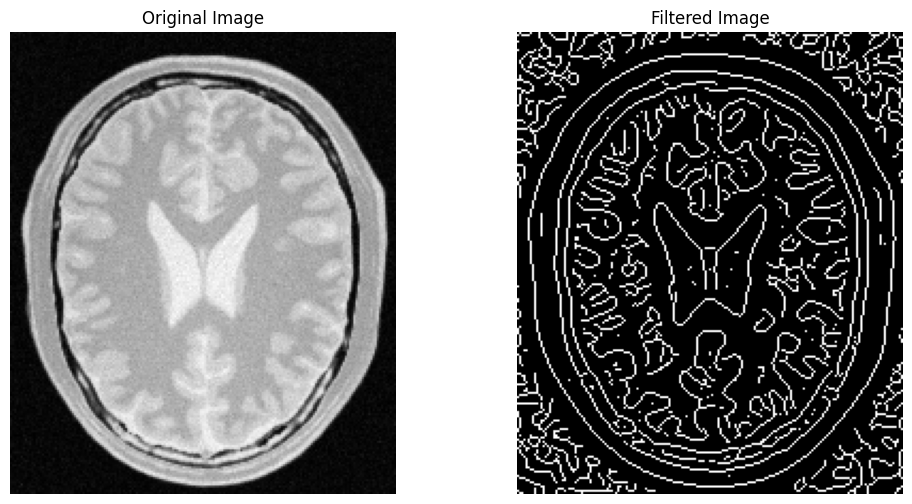

In [11]:
def apply_canny_edge_detection(input_image, lower_threshold, upper_threshold, variance):
    canny_filter = itk.CannyEdgeDetectionImageFilter.New(Input=input_image)
    canny_filter.SetLowerThreshold(lower_threshold)
    canny_filter.SetUpperThreshold(upper_threshold)
    canny_filter.SetVariance(variance)

    # Apply the filter and return the edge-detected image
    canny_filter.Update()
    return canny_filter.GetOutput()

input_image = itk.imread(input_image_path, itk.F)  
# Reading as a float image for edge detection to avoid numerical errors

# Set the Canny edge detection parameters
lower_threshold = 0.1
upper_threshold = 0.3
variance = 5.0  # Gaussian filter variance used in smoothing

# Apply the Canny edge detection
canny_edge_image = apply_canny_edge_detection(input_image, lower_threshold, upper_threshold, variance)

# Display the original and edge-detected images
display_images(input_image, canny_edge_image)



Input image is read as UC (unsigned char) with the use of casting and rescale filters.

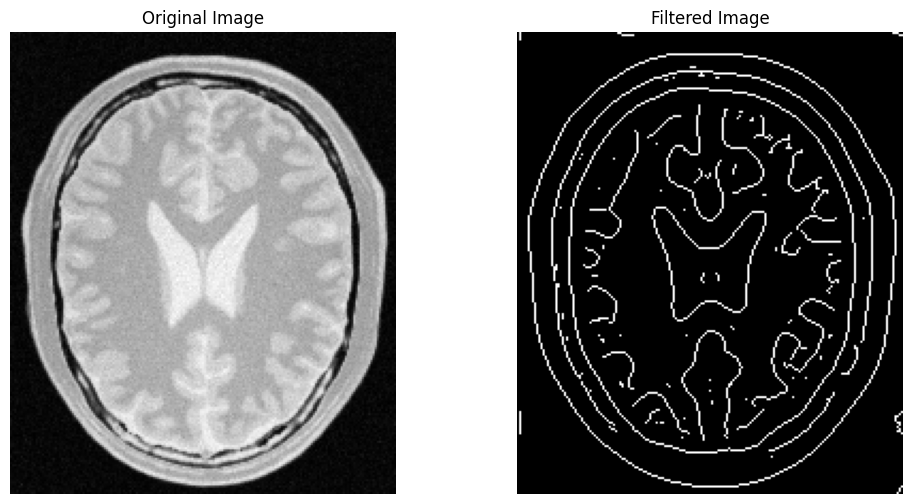

: 

In [36]:
# Function to apply Canny edge detection with casting and rescaling
def apply_canny_edge_detection_cast_rescale(input_image, lower_threshold, upper_threshold, variance):
    # Define pixel types
    CharPixelType = itk.UC  # Unsigned Char
    RealPixelType = itk.F  # Float

    # Define image types
    CharImageType = itk.Image[CharPixelType, 2]
    RealImageType = itk.Image[RealPixelType, 2]

    # Cast input Char image to Real image type
    cast_filter = itk.CastImageFilter[CharImageType, RealImageType].New()
    cast_filter.SetInput(input_image)

    # Create the Canny edge detection filter
    canny_filter = itk.CannyEdgeDetectionImageFilter.New()
    canny_filter.SetInput(cast_filter.GetOutput())
    canny_filter.SetLowerThreshold(lower_threshold)
    canny_filter.SetUpperThreshold(upper_threshold)
    canny_filter.SetVariance(variance)

    # Rescale intensity back to char range after edge detection
    rescale_filter = itk.RescaleIntensityImageFilter[RealImageType, CharImageType].New()
    rescale_filter.SetInput(canny_filter.GetOutput())
    rescale_filter.SetOutputMinimum(0)
    rescale_filter.SetOutputMaximum(255)

    # Update the pipeline and return the processed image
    rescale_filter.Update()
    return rescale_filter.GetOutput()

# Read the input image as CharImageType
input_image = itk.imread(input_image_path, itk.UC)  # Unsigned char type

# Set the Canny edge detection parameters
lower_threshold = 0.2
upper_threshold = 0.3
variance = 20.0  # Gaussian filter variance used in smoothing
maximum_error = 0.01  # Maximum error tolerance in Canny edge computation

# Apply the Canny edge detection with casting and rescaling
canny_edge_image = apply_canny_edge_detection_cast_rescale(input_image, lower_threshold, upper_threshold, variance)

# Display the original and edge-detected images
display_images(input_image, canny_edge_image)


Linear Mapping

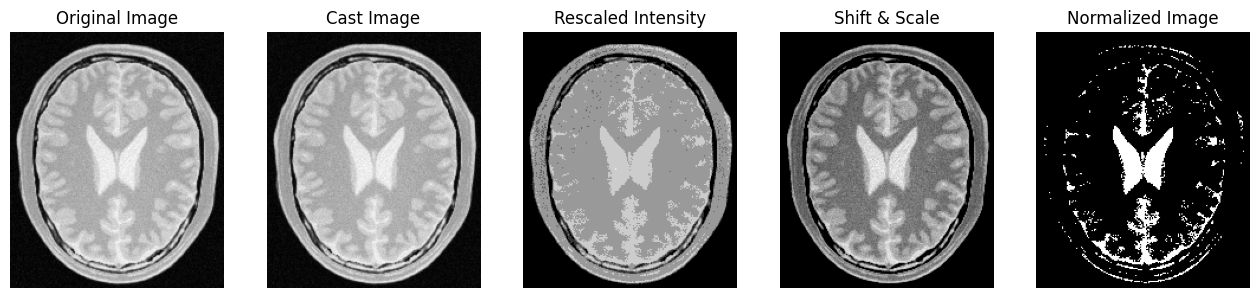

In [15]:
def apply_cast_image_filter(input_image, output_pixel_type):
    InputImageType = type(input_image)
    
    CastFilterType = itk.CastImageFilter[InputImageType, itk.Image[output_pixel_type, input_image.GetImageDimension()]]
    cast_filter = CastFilterType.New(Input=input_image)
    cast_filter.Update()
    return cast_filter.GetOutput()

def apply_rescale_intensity_image_filter(input_image, output_min, output_max):
    rescale_filter = itk.RescaleIntensityImageFilter.New(Input=input_image)
    rescale_filter.SetOutputMinimum(output_min)
    rescale_filter.SetOutputMaximum(output_max)
    rescale_filter.Update()
    return rescale_filter.GetOutput()

def apply_shift_scale_image_filter(input_image, shift, scale):
    shift_scale_filter = itk.ShiftScaleImageFilter.New(Input=input_image)
    shift_scale_filter.SetShift(shift)
    shift_scale_filter.SetScale(scale)
    shift_scale_filter.Update()
    return shift_scale_filter.GetOutput()

def apply_normalize_image_filter(input_image):
    normalize_filter = itk.NormalizeImageFilter.New(Input=input_image)
    normalize_filter.Update()
    return normalize_filter.GetOutput()

def display_images_side_by_side(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(16, 8))
    for i, image in enumerate(images):
        image_array = itk.array_from_image(image)
        axes[i].imshow(image_array, cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()


# Read the input image
input_image_path = 'images\\BrainProtonDensitySlice.png' 
input_image = itk.imread(input_image_path, itk.UC) 

# Apply the filters
cast_image = apply_cast_image_filter(input_image, itk.F)
rescale_image = apply_rescale_intensity_image_filter(input_image, 10, 15)
shift_scale_image = apply_shift_scale_image_filter(input_image, shift=-100, scale=1.5)
normalized_image = apply_normalize_image_filter(input_image)

images = [input_image, cast_image, rescale_image, shift_scale_image, normalized_image]
titles = ['Original Image', 'Cast Image', 'Rescaled Intensity', 'Shift & Scale', 'Normalized Image']

display_images_side_by_side(images, titles)

Non Linear Mapping

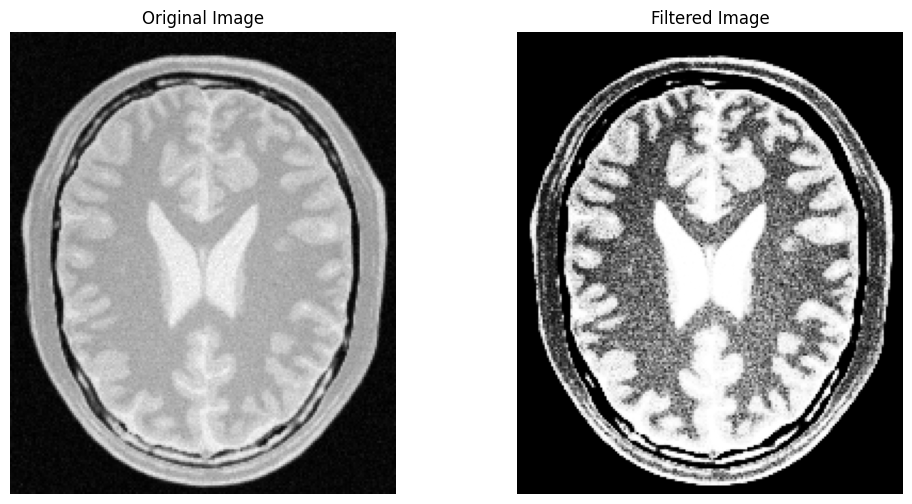

In [23]:
def apply_sigmoid_image_filter(input_image, alpha, beta, output_min, output_max):
    
    # Determine image dimension and pixel type from input image
    InputImageType = type(input_image)
    OutputImageType = InputImageType

    # Create the sigmoid filter with correct template types
    SigmoidFilterType = itk.SigmoidImageFilter[InputImageType, OutputImageType]
    sigmoid_filter = SigmoidFilterType.New()
    
    # Set the parameters of the sigmoid filter
    sigmoid_filter.SetAlpha(alpha)
    sigmoid_filter.SetBeta(beta)
    sigmoid_filter.SetOutputMinimum(output_min)
    sigmoid_filter.SetOutputMaximum(output_max)
    
    # Connect the input image
    sigmoid_filter.SetInput(input_image)
    
    # Update the filter to apply it
    sigmoid_filter.Update()
    
    return sigmoid_filter.GetOutput()

input_image = itk.imread(input_image_path, itk.F)  # Reading image as float for better precision

alpha = 10.0  # Width of the intensity window
beta = 170.0  # Center of the sigmoid curve (intensity value around which sigmoid transitions)
output_min = 10.0  # Minimum value in output image
output_max = 240.0  # Maximum value in output image

sigmoid_image = apply_sigmoid_image_filter(input_image, alpha, beta, output_min, output_max)

display_images(input_image, sigmoid_image)

Gradient Magnitude

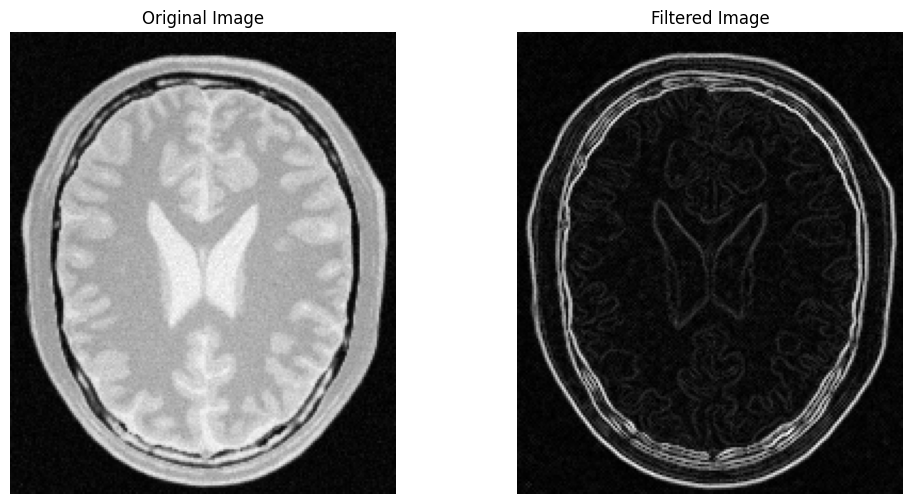

In [16]:
# Function to apply GradientMagnitudeImageFilter
def apply_gradient_magnitude_filter(input_image):
    # Define the filter type using the input image's type
    GradientMagnitudeFilterType = itk.GradientMagnitudeImageFilter[type(input_image), type(input_image)]
    gradient_magnitude_filter = GradientMagnitudeFilterType.New()
    
    # Set the input to the filter
    gradient_magnitude_filter.SetInput(input_image)
    
    # Update the filter to apply the computation
    gradient_magnitude_filter.Update()
    
    return gradient_magnitude_filter.GetOutput()

gradient_magnitude_image = apply_gradient_magnitude_filter(input_image)
display_images(input_image,gradient_magnitude_image)

Gradient Magnitude With Smoothing

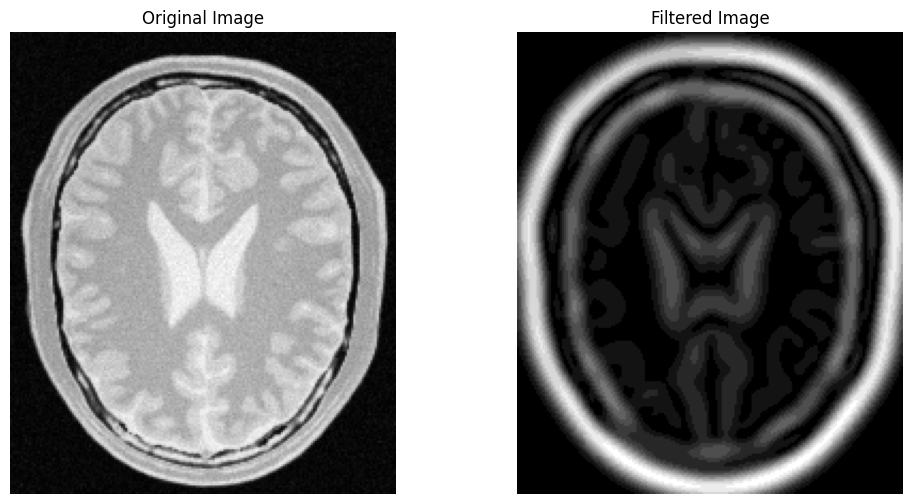

In [19]:
# Function to apply GradientMagnitudeRecursiveGaussianImageFilter
def apply_gradient_magnitude_recursive_gaussian_filter(input_image, sigma=1.0):
    FilterType = itk.GradientMagnitudeRecursiveGaussianImageFilter[type(input_image), type(input_image)]
    gradient_magnitude_recursive_gaussian_filter = FilterType.New()
    gradient_magnitude_recursive_gaussian_filter.SetSigma(sigma)
    gradient_magnitude_recursive_gaussian_filter.SetInput(input_image)
    gradient_magnitude_recursive_gaussian_filter.Update()

    return gradient_magnitude_recursive_gaussian_filter.GetOutput()

sigma_value = 5.0 
gradient_magnitude_recursive_gaussian_image = apply_gradient_magnitude_recursive_gaussian_filter(input_image, sigma=sigma_value)


display_images(input_image, gradient_magnitude_recursive_gaussian_image)


Derivative Without Smoothing


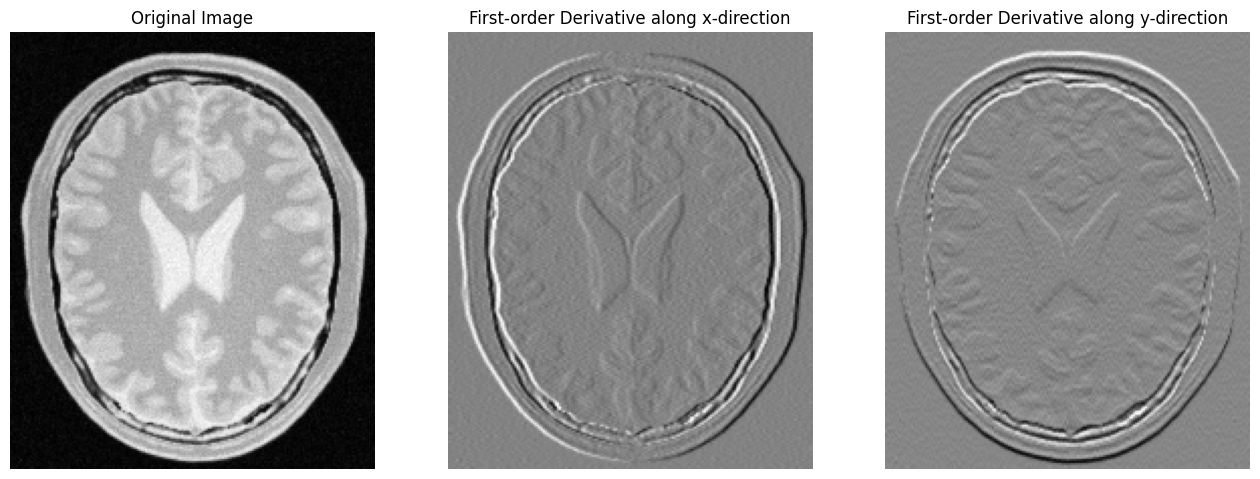

In [24]:
def apply_derivative_image_filter(input_image, order=1, direction=0):
    
    # Define the filter type using the input image's type
    FilterType = itk.DerivativeImageFilter[type(input_image), type(input_image)]
    derivative_filter = FilterType.New()

    # Set the order of the derivative and the direction (0 for x-axis, 1 for y-axis in 2D)
    derivative_filter.SetOrder(order)
    derivative_filter.SetDirection(direction)

    # Set the input to the filter
    derivative_filter.SetInput(input_image)

    # Update the filter to apply the computation
    derivative_filter.Update()

    return derivative_filter.GetOutput()

# Apply DerivativeImageFilter for the first-order derivative along x-direction (direction=0)
derivative_image_x = apply_derivative_image_filter(input_image, order=1, direction=0)

# Apply DerivativeImageFilter for the first-order derivative along y-direction (direction=1)
derivative_image_y = apply_derivative_image_filter(input_image, order=1, direction=1)

images = [input_image, derivative_image_x, derivative_image_y]
titles = ['Original Image', 'First-order Derivative along x-direction', 'First-order Derivative along y-direction']


display_images_side_by_side(images, titles)

Second Order Recursive Gaussian

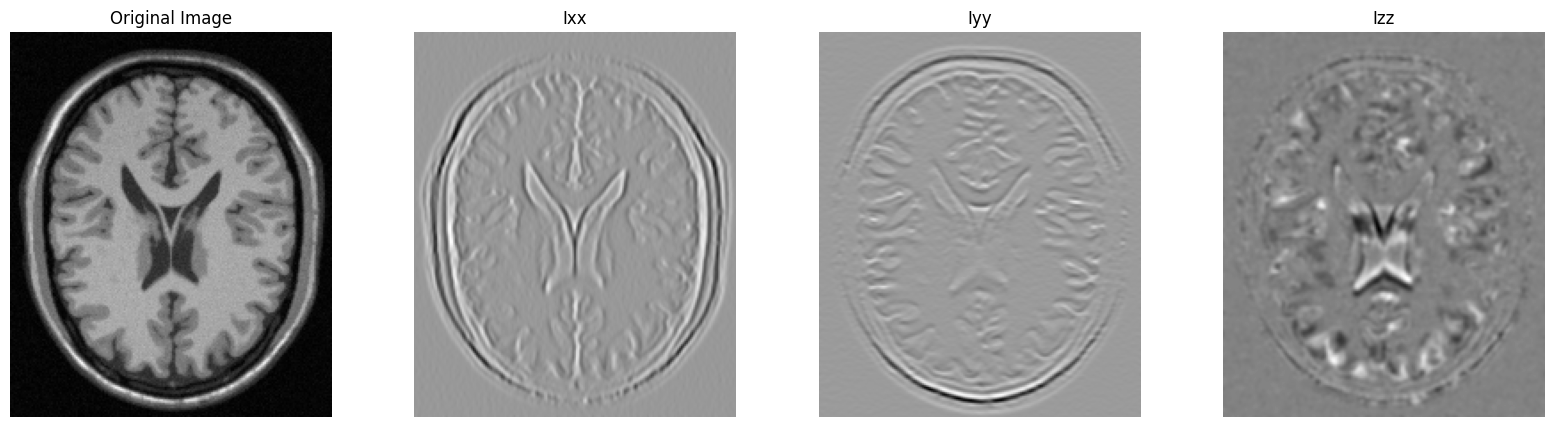

In [30]:
# Define pixel and image types
PixelType = itk.F
Dimension = 3
ImageType = itk.Image[PixelType, Dimension]

input_image_path = "images\\brainweb165a10f17.mha"
reader = itk.ImageFileReader[ImageType].New(FileName=input_image_path)

# Define filter types and duplicator
FilterType = itk.RecursiveGaussianImageFilter[ImageType, ImageType]
DuplicatorType = itk.ImageDuplicator[ImageType]

# Create Gaussian filters
ga = FilterType.New()
gb = FilterType.New()
gc = FilterType.New()

# Set directions for the filters
ga.SetDirection(0)  # X-axis
gb.SetDirection(1)  # Y-axis
gc.SetDirection(2)  # Z-axis

# Set the sigma value (standard deviation of Gaussian kernel)
sigma = 1.0
ga.SetSigma(sigma)
gb.SetSigma(sigma)
gc.SetSigma(sigma)

# Zero-order smoothing in x- and y-directions (smoothing only), second-order derivative in z-direction
ga.SetZeroOrder()
gb.SetZeroOrder()
gc.SetSecondOrder() #Remember gc is taking second derivative

# Input image
ga.SetInput(reader.GetOutput())
gb.SetInput(ga.GetOutput())
gc.SetInput(gb.GetOutput())

# Compute second-order derivative in z-direction (Izz)
duplicator = DuplicatorType.New() # To create separate independent copy of the image
gc.Update()
duplicator.SetInputImage(gc.GetOutput())
duplicator.Update()
Izz = duplicator.GetOutput()

# As we have the entire pipeline created now, we need just to switch directions of gc
# Y-direction second derivative
gc.SetDirection(1)  # Y-axis
gb.SetDirection(2)  # Z-axis
gc.Update()
duplicator.Update()
Iyy = duplicator.GetOutput()

# X-direction second derivative
gc.SetDirection(0)  # X-axis
ga.SetDirection(1)  # Y-axis
gc.Update()
duplicator.Update()
Ixx = duplicator.GetOutput()

# Visualization function
def visualize_slice(image, slice_index):
    array = itk.GetArrayFromImage(image)
    return array[slice_index, :, :]

# Visualize the middle slice
#slice_index = Izz.GetLargestPossibleRegion().GetSize()[2] // 2
slice_index = 90
original_image_slice = visualize_slice(reader.GetOutput(), slice_index)
Ixx_slice = visualize_slice(Ixx, slice_index)
Iyy_slice = visualize_slice(Iyy, slice_index)
Izz_slice = visualize_slice(Izz, slice_index)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(original_image_slice, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(Ixx_slice, cmap='gray')
axes[1].set_title('Ixx')
axes[1].axis('off')

axes[2].imshow(Iyy_slice, cmap='gray')
axes[2].set_title('Iyy')
axes[2].axis('off')

axes[3].imshow(Izz_slice, cmap='gray')
axes[3].set_title('Izz')
axes[3].axis('off')

plt.show()

Laplacian Filters

Recursive Gaussian Image Filter for computing Laplacian.

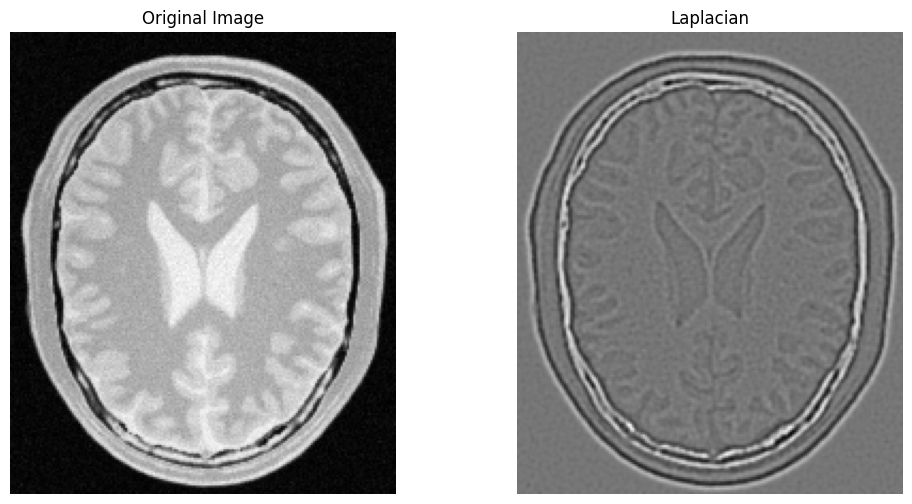

In [31]:
# Define pixel and image types
PixelType = itk.F
Dimension = 2
ImageType = itk.Image[PixelType, Dimension]

input_image_path = 'images\\BrainProtonDensitySlice.png' 
reader = itk.ImageFileReader[ImageType].New(FileName=input_image_path)

# Define filter types
FilterType = itk.RecursiveGaussianImageFilter[ImageType, ImageType]
AddFilterType = itk.AddImageFilter[ImageType, ImageType, ImageType]

# Create Gaussian filters for X and Y directions
filterX1 = FilterType.New()
filterY1 = FilterType.New()
filterX2 = FilterType.New()
filterY2 = FilterType.New()

# Set directions for the filters
filterX1.SetDirection(0)  # X-axis
filterY1.SetDirection(1)  # Y-axis
filterX2.SetDirection(0)  # X-axis
filterY2.SetDirection(1)  # Y-axis

# Set the order for each filter
filterX1.SetZeroOrder()  # X-direction, smoothing only
filterY1.SetSecondOrder()  # Y-direction, second-order derivative
filterX2.SetSecondOrder()  # X-direction, second-order derivative
filterY2.SetZeroOrder()  # Y-direction, smoothing only

# Enable this normalization flag when analyzing an image across scale-space
normalizeAcrossScale = False
filterX1.SetNormalizeAcrossScale(normalizeAcrossScale)
filterY1.SetNormalizeAcrossScale(normalizeAcrossScale)
filterX2.SetNormalizeAcrossScale(normalizeAcrossScale)
filterY2.SetNormalizeAcrossScale(normalizeAcrossScale)

# Set input for the filters
filterX1.SetInput(reader.GetOutput())
filterY1.SetInput(filterX1.GetOutput()) 
#This combination smooths  in the X direction and computes the second derivative along the Y axis, detecting changes along the Y-axis.

filterY2.SetInput(reader.GetOutput())
filterX2.SetInput(filterY2.GetOutput())
#This combination smooths in the Y direction and computes the second derivative along the X-axis, detecting changes along the X-axis.


# Set the sigma value (standard deviation of Gaussian kernel)
sigma = 1.0
filterX1.SetSigma(sigma)
filterY1.SetSigma(sigma)
filterX2.SetSigma(sigma)
filterY2.SetSigma(sigma)

# Compute the Laplacian by adding the filtered images
addFilter = AddFilterType.New()
addFilter.SetInput1(filterY1.GetOutput())
addFilter.SetInput2(filterX2.GetOutput())

# Update the filters
try:
    addFilter.Update()
except itk.ExceptionObject as e:
    print("ExceptionObject caught !")
    print(e)
    exit(1)

# Extract the result
laplacian_image = addFilter.GetOutput()

# Visualization function
def visualize_image(image, title):
    array = itk.GetArrayFromImage(image)
    plt.imshow(array, cmap='gray')
    plt.title(title)
    plt.axis('off')

# Visualize the original image and Laplacian result
original_image = reader.GetOutput()
original_image_slice = itk.GetArrayFromImage(original_image)
laplacian_slice = itk.GetArrayFromImage(laplacian_image)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_image_slice, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(laplacian_slice, cmap='gray')
axes[1].set_title('Laplacian')
axes[1].axis('off')

plt.show()

Laplacian Recursive Gaussian Image Filter for computing Laplacian.

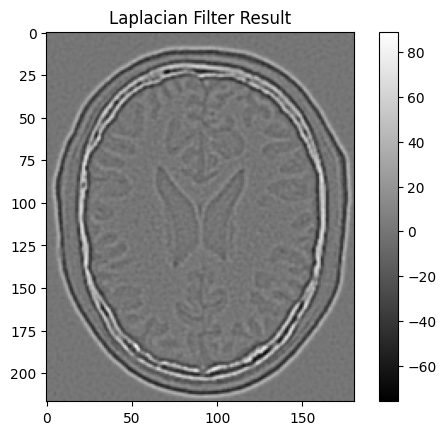

In [32]:
# Define pixel and image types
PixelType = itk.F
Dimension = 2
ImageType = itk.Image[PixelType, Dimension]

input_image_path = 'images\\BrainProtonDensitySlice.png'
reader = itk.ImageFileReader[ImageType].New(FileName=input_image_path)

# Define the Laplacian Recursive Gaussian filter type
LaplacianFilterType = itk.LaplacianRecursiveGaussianImageFilter[ImageType, ImageType]

# Create an instance of the Laplacian filter
laplacian = LaplacianFilterType.New()

# Set the input image to the Laplacian filter
laplacian.SetInput(reader.GetOutput())

# Set the sigma value (standard deviation of Gaussian kernel)
sigma = 1.0
laplacian.SetSigma(sigma)

# Set normalization flag to false as setting it true has no impact because we are renormalizing the output to the dynamic range of the reader.
laplacian.SetNormalizeAcrossScale(False)

# Execute the pipeline
try:
    laplacian.Update()
except itk.ExceptionObject as e:
    print("Exception caught during filtering:")
    print(e)
    exit(1)

# Get the output image
output_image = laplacian.GetOutput()

# Visualize the result
def visualize_image(image):
    array = itk.GetArrayFromImage(image)
    plt.imshow(array, cmap='gray')
    plt.title("Laplacian Filter Result")
    plt.colorbar()
    plt.show()

# Visualize the output image
visualize_image(output_image)